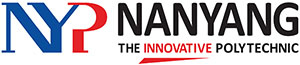

# IT3386 - AI Services in Analytics

## Part 3 - AutoML in Vertex AI

This template contains some steps to help you complete your assignment. Refer to the assignment brief for details on the tasks you are required to perform and add them into the notebook accordingly.

READ ALL INSTRUCTIONS CAREFULLY

### Setup

In [4]:
# add service key json into env
%env GOOGLE_APPLICATION_CREDENTIALS=sa-234201r.json
%env GOOGLE_APPLICATION_CREDENTIALS

env: GOOGLE_APPLICATION_CREDENTIALS=sa-234201r.json


'sa-234201r.json'

In [15]:
# settings
PROJECT_ID = "gcp-pj-vertex-234201r-10f2" 
BUCKET_NAME = PROJECT_ID + "-3386-aip"
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION="us-central1"
print(BUCKET_URI)

gs://gcp-pj-vertex-234201r-10f2-3386-aip


In [16]:
# full path of JSONL file, which you have checked in Part 1 during data preparation
IMPORT_FILE = f"{BUCKET_URI}/ibs_question.jsonl"
print(IMPORT_FILE)

gs://gcp-pj-vertex-234201r-10f2-3386-aip/ibs_question.jsonl


### Initialize SDK

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
import vertexai

# Initialize Vertex AI client
vertexai.init(
    project=PROJECT_ID,
    location=REGION
)

### Perform Fine Tuning

In [18]:
from vertexai.preview.tuning import sft

# ---- Define Base Model ----
BASE_MODEL = "gemini-2.5-flash-lite"  

# ---- Launch Fine-tuning Job ----
tuned_model = sft.train(
    source_model=BASE_MODEL,
    train_dataset=IMPORT_FILE,
    epochs=5, 
    learning_rate_multiplier=1.0,
    tuned_model_display_name="TUNED_MODEL" 
)

print("✅ Fine-tuning job submitted.")
print("Tuned model name:", tuned_model.name)

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/1043018127073/locations/us-central1/tuningJobs/5292919560159100928
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/1043018127073/locations/us-central1/tuningJobs/5292919560159100928')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/5292919560159100928?project=1043018127073


✅ Fine-tuning job submitted.
Tuned model name: 5292919560159100928


### Monitor Fine-Tuning
You can monitor the training by logging on to your Google Cloud Console. You can also take screenshots of some of the training metrics to put in your report from the cloud console. 

If you want, you can also check the training progress by running the cell below. 

In [ ]:
# JOB_STATE_UNSPECIFIED	0	Default / unknown
# JOB_STATE_QUEUED / PENDING	1	Job is queued, waiting for resources
# JOB_STATE_PENDING	2	Job has been scheduled, not started
# JOB_STATE_RUNNING	3	Job is actively running (training/fine-tuning in progress)
# JOB_STATE_SUCCEEDED	4	Job completed successfully
# JOB_STATE_FAILED	5	Job failed
# JOB_STATE_CANCELLING	6	Job is being cancelled
# JOB_STATE_CANCELLED	7	Job was cancelled

In [20]:
current_job = sft.SupervisedTuningJob(tuned_model.name)
state = current_job.state
print(f"Job state: {state}")

Job state: 4


### Cancelling the job

In case you need to cancel the job, you can run the following code. Take note of the job name which is given in the output of the training cell above.

In [ ]:
from vertexai.tuning import sft

# Your job resource name
job_name = "projects/YOUR_PROJECT_ID/locations/us-central1/tuningJobs/YOUR_JOB_ID"

# Retrieve the job
job = sft.SupervisedTuningJob(job_name)

# Cancel the job
job.cancel()
print(f"✅ Job {job_name} cancellation requested.")

### Test the Model

In [21]:
# get the model name and location
print("Tuned model name (once finished):", current_job.tuned_model_name)

Tuned model name (once finished): projects/1043018127073/locations/us-central1/models/7591493371584053248@1


In [ ]:
from vertexai.generative_models import GenerativeModel

tuned_model = GenerativeModel(current_job.tuned_model_endpoint_name)
print(tuned_model.generate_content("What are lab safety rules?")) #insert your question

### Create a UI for your fine tuned model

You can use a simple UI in python, or you can use tools such as Gradio to build this. Test your fine tuned model with your testing examples. You can provide screenshots in the report.

In [24]:
import vertexai

# Fill these in and run the cell!
PROJECT_ID = "gcp-pj-vertex-234201r-10f2" 
REGION="us-central1"

# Initialize Vertex AI client
vertexai.init(
    project=PROJECT_ID,
    location=REGION
)

In [ ]:
TUNED_MODEL_RESOURCE_NAME = "projects/1043018127073/locations/us-central1/endpoints/6146418433337589760" 

In [ ]:
import gradio as gr
from vertexai.generative_models import GenerativeModel
from typing import List, Tuple

# ----------------------------------------------------------------------
# 1. SETUP: Fill in your specific details
# ----------------------------------------------------------------------

TUNED_MODEL_RESOURCE_NAME = "projects/1043018127073/locations/us-central1/endpoints/6146418433337589760" 
BASE_MODEL_NAME = "gemini-2.5-flash-lite"

SYSTEM_INSTRUCTION = (
    "You are an expert IBS and low-FODMAP dietary assistant. "
    "Respond to all user questions with the concise and direct answer. "
    "Your response must be matching the length of the training examples. "
    "Omit all greetings, pleasantries, and unnecessary elaboration."
)

# The 5 test questions (for quick testing)
TEST_QUESTIONS = [
    "Is garlic considered low-FODMAP or high-FODMAP, and which FODMAP group does it belong to?",
    "During which phase of the low-FODMAP diet should lactose-containing foods be tested, and why?",
    "What are two low-FODMAP alternatives someone could use instead of wheat-based bread?",
    "Why is the low-FODMAP diet not intended to be a lifelong elimination diet?",
    "A person with IBS experiences bloating mainly after eating apples and pears. Which FODMAP category is most likely responsible?"
]

# ----------------------------------------------------------------------
# 2. HELPER FUNCTIONS
# ----------------------------------------------------------------------

def call_gemini_model(model_identifier: str, prompt: str) -> str:
    """Standardized function to call the Gemini API via Vertex AI SDK."""
    try:
        model = GenerativeModel(model_identifier)
        
        # FINAL FIX: Prepend the instruction directly to the prompt for maximum compatibility.
        concise_prompt = f"{SYSTEM_INSTRUCTION}\n\nUser Question: {prompt}"
        
        # CRITICAL: Do NOT pass the 'config' argument or 'system_instruction' parameter, 
        # as your SDK version rejects it for both models.
        response = model.generate_content(concise_prompt) 
            
        return response.text
    except Exception as e:
        # Keep the detailed error logging for any other issues
        return f"Error: Could not connect to model '{model_identifier}'. Details: {e}"


def fine_tuned_chat(prompt: str, history: List[Tuple[str, str]]) -> str:
    """Function for the Fine-Tuned Model tab."""
    # Note: TUNED_MODEL_ENDPOINT_NAME should be the one from your screenshot
    return call_gemini_model(TUNED_MODEL_RESOURCE_NAME, prompt)

def base_model_chat(prompt: str, history: List[Tuple[str, str]]) -> str:
    """Function for the Base Model tab."""
    return call_gemini_model(BASE_MODEL_NAME, prompt)

# ----------------------------------------------------------------------
# 3. GRADIO UI DEFINITION (CLEAN & MINIMAL - FIXED)
# ----------------------------------------------------------------------

with gr.Blocks(title="IBS Assistant Model Comparison") as demo:
    gr.Markdown("# 🔍 Minimal IBS Assistant: Model Comparison")
    gr.Markdown(
        "Use the tabs below to test your Fine-Tuned Model against the Base Gemini 2.5 Flash Lite Model. Click the example questions to quickly run the tests."
    )
    
    with gr.Tabs():
        
        # --- Tab 1: Fine-Tuned Model ---
        with gr.TabItem("Fine-Tuned Model"):
            gr.Markdown(f"Connected to: **{TUNED_MODEL_RESOURCE_NAME}**")
            gr.ChatInterface(
                fn=fine_tuned_chat,
                chatbot=gr.Chatbot(height=400, label="Fine-Tuned IBS/FODMAP Assistant"),
                textbox=gr.Textbox(placeholder="Ask your specialized question here...", container=False),
                examples=TEST_QUESTIONS, 
                title="", 
                submit_btn="Ask Fine-Tuned Model",
                # REMOVED: clear_btn="Clear History"
            )

        # --- Tab 2: Base Model ---
        with gr.TabItem("Base Model (Comparison)"):
            gr.Markdown(f"Connected to: **{BASE_MODEL_NAME}**")
            gr.ChatInterface(
                fn=base_model_chat,
                chatbot=gr.Chatbot(height=400, label="Base Gemini 2.5 Flash Lite"),
                textbox=gr.Textbox(placeholder="Ask the base model...", container=False),
                examples=TEST_QUESTIONS,
                title="", 
                submit_btn="Ask Base Model",
                # REMOVED: clear_btn="Clear History"
            )

# Launch the interface
demo.launch(inbrowser=False, share=False)

C:\Users\User\AppData\Local\Temp\ipykernel_25300\1397603622.py:74: UserWarning: You provided a custom `textbox` component, but also specified `submit_btn` parameter(s) on `gr.ChatInterface`. These ChatInterface parameters will be ignored. To customize these settings, pass them directly to your `gr.Textbox` or `gr.MultimodalTextbox` component instead. For example: textbox=gr.Textbox(..., submit_btn='submit')
  gr.ChatInterface(
C:\Users\User\AppData\Local\Temp\ipykernel_25300\1397603622.py:87: UserWarning: You provided a custom `textbox` component, but also specified `submit_btn` parameter(s) on `gr.ChatInterface`. These ChatInterface parameters will be ignored. To customize these settings, pass them directly to your `gr.Textbox` or `gr.MultimodalTextbox` component instead. For example: textbox=gr.Textbox(..., submit_btn='submit')
  gr.ChatInterface(


* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.googl

Test the same examples with the non-fine tuned model. You can refer to Practical 5 or any other resources to do this. Provide screenshots and discussion in your report.

You can also discuss how you would perform testing if you have a large number of testing samples

In [51]:
from rouge_score import rouge_scorer
import pandas as pd

# -----------------------
# 1) Data
# -----------------------
references = [
    "Garlic is high-FODMAP and belongs to the fructan group.",
    "Lactose should be tested during the reintroduction phase to determine individual tolerance levels.",
    "Sourdough spelt bread and rice bread are two low-FODMAP alternatives to wheat-based bread.",
    "The low-FODMAP diet is a temporary elimination and reintroduction process designed to identify specific trigger foods.",
    "The FODMAP category most likely responsible is fructans and/or excess fructose."
]

base_outputs = [
    "Garlic is high-FODMAP, belonging to the fructan group.",
    "Lactose-containing foods should be tested during the reintroduction phase, as this phase aims to identify specific FODMAP intolerances.",
    "Rice bread, sourdough rye bread.",
    "It's a temporary elimination and reintroduction diet to identify trigger foods.",
    "Fructans"
]

tuned_outputs = [
    "Garlic is high-FODMAP and belongs to the fructan group.",
    "Lactose should be tested during the reintroduction phase because it is a specific FODMAP that may or may not trigger IBS symptoms.",
    "Sourdough spelt bread, rice bread.",
    "It's a temporary elimination and reintroduction diet to identify trigger foods.",
    "Fructans"
]

assert len(references) == len(base_outputs) == len(tuned_outputs)

# -----------------------
# 2) ROUGE scorer
# -----------------------
scorer = rouge_scorer.RougeScorer(
    ["rouge1", "rougeL"],
    use_stemmer=True
)

# -----------------------
# 3) Compute ROUGE
# -----------------------
rows = []

for i, (ref, base, tuned) in enumerate(zip(references, base_outputs, tuned_outputs), start=1):
    base_score = scorer.score(ref, base)
    tuned_score = scorer.score(ref, tuned)

    rows.append({
        "Q#": i,
        "ROUGE-1 Base": base_score["rouge1"].fmeasure,
        "ROUGE-1 Tuned": tuned_score["rouge1"].fmeasure,
        "ROUGE-L Base": base_score["rougeL"].fmeasure,
        "ROUGE-L Tuned": tuned_score["rougeL"].fmeasure,
        "Δ ROUGE-L (Tuned - Base)": tuned_score["rougeL"].fmeasure - base_score["rougeL"].fmeasure
    })

df = pd.DataFrame(rows)

# -----------------------
# 4) Round numeric columns safely
# -----------------------
df_display = df.copy()
for col in df_display.columns:
    if pd.api.types.is_numeric_dtype(df_display[col]):
        df_display[col] = df_display[col].round(4)

# -----------------------
# 5) Summary table
# -----------------------
summary = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-L"],
    "Base (mean)": [
        df["ROUGE-1 Base"].mean(),
        df["ROUGE-L Base"].mean()
    ],
    "Fine-tuned (mean)": [
        df["ROUGE-1 Tuned"].mean(),
        df["ROUGE-L Tuned"].mean()
    ],
    "Δ (Tuned - Base)": [
        df["ROUGE-1 Tuned"].mean() - df["ROUGE-1 Base"].mean(),
        df["ROUGE-L Tuned"].mean() - df["ROUGE-L Base"].mean()
    ]
})

summary_display = summary.copy()
for col in summary_display.columns:
    if pd.api.types.is_numeric_dtype(summary_display[col]):
        summary_display[col] = summary_display[col].round(4)

# -----------------------
# 6) Display results
# -----------------------
print("Per-question ROUGE scores")
display(df_display)

print("\nOverall ROUGE comparison")
display(summary_display)


Per-question ROUGE scores


,Q#,ROUGE-1 Base,ROUGE-1 Tuned,ROUGE-L Base,ROUGE-L Tuned,Δ ROUGE-L (Tuned - Base)
0,1,0.9474,1.0000,0.9474,1.0000,0.0526
1,2,0.5625,0.4571,0.5625,0.4571,-0.1054
2,3,0.4000,0.5000,0.3000,0.5000,0.2000
3,4,0.6897,0.6897,0.6207,0.6207,0.0000
4,5,0.1538,0.1538,0.1538,0.1538,0.0000



Overall ROUGE comparison


,Metric,Base (mean),Fine-tuned (mean),Δ (Tuned - Base)
0,ROUGE-1,0.5507,0.5601,0.0095
1,ROUGE-L,0.5169,0.5463,0.0295


### Deleting models and endpoints

You can list all your fine tuned models by running the code below

In [6]:
PROJECT_ID = "gcp-pj-vertex-234201r-10f2"
REGION="us-central1"
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=REGION)
models = aiplatform.Model.list()
for model in models:
    print(model.resource_name, " | ", model.display_name)

projects/1043018127073/locations/us-central1/models/7591493371584053248  |  TUNED_MODEL


To delete a specific model:

In [10]:
model = aiplatform.Model("7591493371584053248")
model.delete()

Deleting Model : projects/1043018127073/locations/us-central1/models/7591493371584053248
Model deleted. . Resource name: projects/1043018127073/locations/us-central1/models/7591493371584053248
Deleting Model resource: projects/1043018127073/locations/us-central1/models/7591493371584053248
Delete Model backing LRO: projects/1043018127073/locations/us-central1/models/7591493371584053248/operations/6780982516833583104
Model resource projects/1043018127073/locations/us-central1/models/7591493371584053248 deleted.



When you are done with predictions, delete the endpoints to undeploy the model

<span style="color:red">Once you undeploy your model, you will not be able to perform any predictions so make sure you have gathered all the results you need before you undeploy. You will be penalised under if you fail to delete the endpoint.</span>

Run the code below to delete all endpoints

In [9]:

endpoints = aiplatform.Endpoint.list()
for ep in endpoints:
    print(ep.display_name, ep.resource_name)
    endpoint = aiplatform.Endpoint(ep.resource_name)
    endpoint.undeploy_all()
    endpoint.delete()

TUNED_MODEL projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Undeploying Endpoint model: projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Undeploy Endpoint model backing LRO: projects/1043018127073/locations/us-central1/endpoints/6146418433337589760/operations/322539176207581184
Endpoint model undeployed. Resource name: projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Deleting Endpoint : projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Endpoint deleted. . Resource name: projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Deleting Endpoint resource: projects/1043018127073/locations/us-central1/endpoints/6146418433337589760
Delete Endpoint backing LRO: projects/1043018127073/locations/us-central1/operations/2238820817653727232
Endpoint resource projects/1043018127073/locations/us-central1/endpoints/6146418433337589760 deleted.
TUNED_MODEL projects/1043018127073/l

### Additional Work

Remember to outline how would you build a RAG system in Vertex AI for the same task in the report. You can also implement it if you want

### Initialize variables to implement RAG

In [ ]:
import vertexai
from google.cloud import aiplatform

PROJECT_ID = "gcp-pj-vertex-234201r-10f2"
REGION = "us-central1"   

vertexai.init(project=PROJECT_ID, location=REGION)
aiplatform.init(project=PROJECT_ID, location=REGION)


In [55]:
BUCKET_NAME = PROJECT_ID + "-3386-aip-rag"
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [56]:
print(BUCKET_URI)

gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag


In [57]:
from google.cloud import storage
%env GOOGLE_APPLICATION_CREDENTIALS=sa-234201r.json 
%env GOOGLE_APPLICATION_CREDENTIALS

env: GOOGLE_APPLICATION_CREDENTIALS=sa-234201r.json


'sa-234201r.json'

### Upload the pdf that will be digested into knowledge base into a bucket

In [58]:
# Instantiates a client
storage_client = storage.Client()

In [59]:
#Create a bucket
#https://cloud.google.com/storage/docs/creating-buckets#storage-create-bucket-client_libraries
my_bucket = storage_client.create_bucket(BUCKET_NAME)

In [61]:
!dir rag_file

 Volume in drive D has no label.
 Volume Serial Number is A27C-7191

 Directory of d:\Chrome download\rag_file

12/13/2025  10:27 PM    <DIR>          .
12/13/2025  10:27 PM    <DIR>          ..
12/12/2025  08:27 PM           295,995 Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf
12/12/2025  08:27 PM           266,895 FODMAP-diet.pdf
12/12/2025  08:27 PM           366,203 fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf
12/12/2025  08:27 PM           627,924 FODMAP_dietsheet_for_website.pdf
12/12/2025  08:27 PM           155,925 irritable-bowel-diet-sheet.pdf
12/12/2025  08:27 PM         3,220,843 NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf
               6 File(s)      4,933,785 bytes
               2 Dir(s)  743,318,732,800 bytes free


In [62]:
def upload_directory_with_transfer_manager(bucket, source_directory, workers=8):
    """Upload every file in a directory, including all files in subdirectories.

    Each blob name is derived from the filename, not including the `directory`
    parameter itself. For complete control of the blob name for each file (and
    other aspects of individual blob metadata), use
    transfer_manager.upload_many() instead.
    """

    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The directory on your computer to upload. Files in the directory and its
    # subdirectories will be uploaded. An empty string means "the current
    # working directory".
    # source_directory=""

    # The maximum number of processes to use for the operation. The performance
    # impact of this value depends on the use case, but smaller files usually
    # benefit from a higher number of processes. Each additional process occupies
    # some CPU and memory resources until finished. Threads can be used instead
    # of processes by passing `worker_type=transfer_manager.THREAD`.
    # workers=8

    from pathlib import Path

    from google.cloud.storage import Client, transfer_manager

    # Generate a list of paths (in string form) relative to the `directory`.
    # This can be done in a single list comprehension, but is expanded into
    # multiple lines here for clarity.

    # First, recursively get all files in `directory` as Path objects.
    directory_as_path_obj = Path(source_directory)
    paths = directory_as_path_obj.rglob("*")

    # Filter so the list only includes files, not directories themselves.
    file_paths = [path for path in paths if path.is_file()]

    # These paths are relative to the current working directory. Next, make them
    # relative to `directory`
    relative_paths = [path.relative_to(source_directory) for path in file_paths]

    # Finally, convert them all to strings.
    string_paths = [str(path) for path in relative_paths]

    print("Found {} files.".format(len(string_paths)))
    
    # filenames must in forward slashes to create the corresponding folder inside bucket
    string_paths[:] = [Path(path).as_posix() for path in string_paths]
    
    # Start the upload.
    results = transfer_manager.upload_many_from_filenames(
        bucket, string_paths, source_directory=source_directory, max_workers=workers
    )

    for name, result in zip(string_paths, results):
        # The results list is either `None` or an exception for each filename in
        # the input list, in order.

        if isinstance(result, Exception):
            print("Failed to upload {} due to exception: {}".format(name, result))
        else:
            print("Uploaded {} to {}.".format(name, bucket.name))

In [63]:
# upload all files inside "rag_file" folder to bucket
upload_directory_with_transfer_manager(my_bucket, 'rag_file')

c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\google_crc32c\__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


Found 6 files.
Uploaded Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.
Uploaded FODMAP-diet.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.
Uploaded fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.
Uploaded FODMAP_dietsheet_for_website.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.
Uploaded irritable-bowel-diet-sheet.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.
Uploaded NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf to gcp-pj-vertex-234201r-10f2-3386-aip-rag.


In [65]:
from google.cloud import storage

PREFIX = ""
BUCKET = "gcp-pj-vertex-234201r-10f2-3386-aip-rag"

vertexai.init(project=PROJECT_ID, location=REGION)
aiplatform.init(project=PROJECT_ID, location=REGION)

pdf_blobs = []
for b in storage_client.list_blobs(BUCKET, prefix=PREFIX):
    if b.name.lower().endswith(".pdf"):
        pdf_blobs.append(b.name)

print("Found PDFs:")
for n in pdf_blobs:
    print("-", n)


Found PDFs:
- Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf
- FODMAP-diet.pdf
- FODMAP_dietsheet_for_website.pdf
- NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf
- fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf
- irritable-bowel-diet-sheet.pdf


### Document Ingestion: Extract PDF Text

In [66]:
from pypdf import PdfReader
from pathlib import Path

bucket = storage_client.bucket(BUCKET)

LOCAL_DIR = Path("pdf_cache")
LOCAL_DIR.mkdir(exist_ok=True)

def download_blob_to_local(blob_name: str) -> Path:
    local_path = LOCAL_DIR / Path(blob_name).name
    blob = bucket.blob(blob_name)
    blob.download_to_filename(str(local_path))
    return local_path

def extract_pdf_text(pdf_path: Path) -> str:
    reader = PdfReader(str(pdf_path))
    pages = []
    for i, page in enumerate(reader.pages):
        txt = page.extract_text() or ""
        pages.append(f"\n\n--- PAGE {i+1} ---\n{txt}")
    return "\n".join(pages).strip()

docs = []
for blob_name in pdf_blobs:
    local_pdf = download_blob_to_local(blob_name)
    text = extract_pdf_text(local_pdf)
    docs.append({
        "gcs_blob": blob_name,
        "local_file": str(local_pdf),
        "text": text
    })

# quick check
for d in docs:
    print(Path(d["local_file"]).name, "chars:", len(d["text"]))


Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf chars: 14264
FODMAP-diet.pdf chars: 14
FODMAP_dietsheet_for_website.pdf chars: 19252
NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf chars: 48670
fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf chars: 10044
irritable-bowel-diet-sheet.pdf chars: 14886


### Check if pdf contain image

In [67]:
def is_probably_image_pdf(text: str, min_chars=200) -> bool:
    return len(text.strip()) < min_chars

for d in docs:
    print(Path(d["local_file"]).name, "image_pdf?", is_probably_image_pdf(d["text"]))


Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf image_pdf? False
FODMAP-diet.pdf image_pdf? True
FODMAP_dietsheet_for_website.pdf image_pdf? False
NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf image_pdf? False
fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf image_pdf? False
irritable-bowel-diet-sheet.pdf image_pdf? False


### Chunking data (split text into small units)

In [71]:
import re

def normalize_text(t: str) -> str:
    t = re.sub(r"\r", "\n", t)
    t = re.sub(r"[ \t]+", " ", t)
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()

def chunk_text_safe(text: str, chunk_size=2500, overlap=250, hard_max=6000):
    """
    chunk_size/overlap/hard_max are in characters.
    hard_max prevents any single chunk from becoming huge (and blowing token limits).
    """
    text = normalize_text(text)
    if not text:
        return []

    # First pass: sliding window chunks
    chunks = []
    start = 0
    while start < len(text):
        end = min(len(text), start + chunk_size)
        chunks.append(text[start:end])
        if end == len(text):
            break
        start = max(0, end - overlap)

    # Second pass: hard split anything still too large
    final_chunks = []
    for ch in chunks:
        if len(ch) <= hard_max:
            final_chunks.append(ch)
        else:
            # split big chunk into hard_max pieces with small overlap
            s = 0
            while s < len(ch):
                e = min(len(ch), s + hard_max)
                final_chunks.append(ch[s:e])
                if e == len(ch):
                    break
                s = max(0, e - 200)  # overlap inside hard split

    return [c.strip() for c in final_chunks if c.strip()]


In [74]:
from pathlib import Path

chunk_records = []
for d in docs:
    chunks = chunk_text_safe(d["text"], chunk_size=2500, overlap=250, hard_max=6000)
    for idx, ch in enumerate(chunks):
        chunk_records.append({
            "doc_id": Path(d["local_file"]).name,
            "gcs_blob": d["gcs_blob"],
            "chunk_id": idx,
            "text": ch
        })

print("✅ Total chunks:", len(chunk_records))
print("✅ Max chunk chars:", max(len(r["text"]) for r in chunk_records))


✅ Total chunks: 49
✅ Max chunk chars: 2500


### Embedding generation

In [78]:
from vertexai.language_models import TextEmbeddingModel

embed_model = TextEmbeddingModel.from_pretrained("text-embedding-004")

def embed_texts(texts):
    embs = embed_model.get_embeddings(texts, auto_truncate=True)
    return [e.values for e in embs]

# test
vec = embed_texts([chunk_records[0]["text"]])[0]
print("Embedding dim:", len(vec))


Embedding dim: 768


In [79]:
import json
from pathlib import Path

BATCH = 16
out_jsonl = Path("datapoints.jsonl")

with out_jsonl.open("w", encoding="utf-8") as f:
    for i in range(0, len(chunk_records), BATCH):
        batch = chunk_records[i:i+BATCH]
        vectors = embed_texts([b["text"] for b in batch])
        for b, v in zip(batch, vectors):
            dp = {
                "id": f'{b["doc_id"]}::chunk_{b["chunk_id"]}',
                "embedding": v,
                "metadata": {
                    "doc_id": b["doc_id"],
                    "gcs_blob": b["gcs_blob"],
                    "chunk_id": b["chunk_id"],
                }
            }
            f.write(json.dumps(dp) + "\n")

print("Wrote", out_jsonl, "lines:", sum(1 for _ in out_jsonl.open("r", encoding="utf-8")))


Wrote datapoints.jsonl lines: 49


### Vector databasse / Index creation (Vertex AI vector search)

In [80]:
INDEX_DATA_GCS = "ibs_rag/index_data/datapoints.jsonl"  # folder inside bucket
bucket.blob(INDEX_DATA_GCS).upload_from_filename(str(out_jsonl))
print("Uploaded to gs://{}/{}".format(BUCKET, INDEX_DATA_GCS))


Uploaded to gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag/ibs_rag/index_data/datapoints.jsonl


In [86]:
BUCKET_NAME = PROJECT_ID + "-3386-aip-rag-uc1"
BUCKET_URI = f"gs://{BUCKET_NAME}"

client = storage.Client(project=PROJECT_ID)

bucket = client.bucket(BUCKET_NAME)

# IMPORTANT: location is set HERE (cannot be changed later)
bucket.location = "us-central1"

bucket = client.create_bucket(bucket)

print("Bucket created:", BUCKET_URI)
print("Location:", bucket.location)

C:\Users\User\AppData\Local\Temp\ipykernel_25300\474687600.py:9: DeprecationWarning: Assignment to 'Bucket.location' is deprecated, as it is only valid before the bucket is created. Instead, pass the location to `Bucket.create`.
  bucket.location = "us-central1"


Bucket created: gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1
Location: US-CENTRAL1


In [87]:
SRC_BUCKET = "gcp-pj-vertex-234201r-10f2-3386-aip-rag"
DST_BUCKET = BUCKET_NAME

src_bucket = client.bucket(SRC_BUCKET)
dst_bucket = client.bucket(DST_BUCKET)

for blob in client.list_blobs(SRC_BUCKET):
    print("Copying:", blob.name)
    src_bucket.copy_blob(blob, dst_bucket, blob.name)

print("All files copied")


Copying: Dietary-advice-for-patients-with-Irritable-Bowel-Syndrome-IBS.pdf
Copying: FODMAP-diet.pdf
Copying: FODMAP_dietsheet_for_website.pdf
Copying: NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf
Copying: fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf
Copying: ibs_rag/index_data/datapoints.jsonl
Copying: irritable-bowel-diet-sheet.pdf
All files copied


In [88]:
import vertexai
from google.cloud import aiplatform

PROJECT_ID = "gcp-pj-vertex-234201r-10f2"
REGION = "us-central1"
BUCKET = "gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1" 

vertexai.init(project=PROJECT_ID, location=REGION)
aiplatform.init(project=PROJECT_ID, location=REGION)

print("Vertex initialised in", REGION)
print("Using bucket:", BUCKET)


Vertex initialised in us-central1
Using bucket: gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1


In [89]:
INDEX_DIR = "ibs_rag/index_data/"
GCS_CONTENT_URI = f"gs://{BUCKET}/{INDEX_DIR}"

print("Index data:", GCS_CONTENT_URI)

Index data: gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1/ibs_rag/index_data/


In [90]:
# quick test embedding
test_vec = embed_texts(["test"])[0]
DIMENSIONS = len(test_vec)

print("✅ Embedding dimension:", DIMENSIONS)


✅ Embedding dimension: 768


### *Move data from a bucket to another with correct geographic region - bug fix/troubleshooting

In [92]:
from google.cloud import storage

PROJECT_ID = "YOUR_PROJECT_ID"
BUCKET = "gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1"

SRC_BLOB = "ibs_rag/index_data/datapoints.jsonl"
DST_BLOB = "ibs_rag/index_data/datapoints.json"

client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET)

src = bucket.blob(SRC_BLOB)
dst = bucket.blob(DST_BLOB)

# Copy (server-side)
bucket.copy_blob(src, bucket, DST_BLOB)

print("Copied to:", f"gs://{BUCKET}/{DST_BLOB}")
print("Exists .json?", bucket.blob(DST_BLOB).exists(client))


Copied to: gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1/ibs_rag/index_data/datapoints.json
Exists .json? True


In [93]:
bucket.blob(SRC_BLOB).delete()
print("Deleted:", f"gs://{BUCKET}/{SRC_BLOB}")


Deleted: gs://gcp-pj-vertex-234201r-10f2-3386-aip-rag-uc1/ibs_rag/index_data/datapoints.jsonl


In [94]:
from google.cloud import aiplatform

index = aiplatform.MatchingEngineIndex.create_brute_force_index(
    display_name="ibs-fodmap-bf-index",
    contents_delta_uri=GCS_CONTENT_URI,
    dimensions=DIMENSIONS,
    distance_measure_type="DOT_PRODUCT_DISTANCE",
    index_update_method="batch_update",
)

print("Index created:")
print(index.resource_name)


Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/1043018127073/locations/us-central1/indexes/3659678273564049408/operations/7869657358006222848
MatchingEngineIndex created. Resource name: projects/1043018127073/locations/us-central1/indexes/3659678273564049408
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/1043018127073/locations/us-central1/indexes/3659678273564049408')
Index created:
projects/1043018127073/locations/us-central1/indexes/3659678273564049408


In [96]:
from google.cloud import aiplatform

PROJECT_ID = "gcp-pj-vertex-234201r-10f2"
REGION = "us-central1"

aiplatform.init(project=PROJECT_ID, location=REGION)

endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name="ibs-fodmap-index-endpoint",
    public_endpoint_enabled=True,   
)

print("Endpoint created:")
print("Endpoint resource:", endpoint.resource_name)


Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960/operations/3406871602258771968
MatchingEngineIndexEndpoint created. Resource name: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960')
Endpoint created:
Endpoint resource: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960


In [97]:
DEPLOYED_INDEX_ID = "ibs_fodmap_v1"  

endpoint.deploy_index(
    index=index,                   
    deployed_index_id=DEPLOYED_INDEX_ID
)

print("Index deployed!")
print("Deployed Index ID:", DEPLOYED_INDEX_ID)


Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960/operations/2028770116283400192
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/1043018127073/locations/us-central1/indexEndpoints/8325732942961704960
Index deployed!
Deployed Index ID: ibs_fodmap_v1


In [98]:
def retrieve_neighbors(query: str, top_k: int = 5):
    qvec = embed_texts([query])[0]
    res = endpoint.find_neighbors(
        deployed_index_id=DEPLOYED_INDEX_ID,
        queries=[qvec],
        num_neighbors=top_k
    )
    return [{"id": n.id, "distance": n.distance} for n in res[0]]

print(retrieve_neighbors("Is garlic high FODMAP?", top_k=5))


[{'id': 'FODMAP_dietsheet_for_website.pdf::chunk_4', 'distance': 0.7334033250808716}, {'id': 'fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf::chunk_0', 'distance': 0.6978826522827148}, {'id': 'fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf::chunk_1', 'distance': 0.6945638656616211}, {'id': 'fodmap-gentle-approach-for-irritable-bowel-syndrome_aug24.pdf::chunk_2', 'distance': 0.6720167398452759}, {'id': 'NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf::chunk_10', 'distance': 0.6611894369125366}]


In [99]:
id_to_chunk = {
    f'{r["doc_id"]}::chunk_{r["chunk_id"]}': r
    for r in chunk_records
}
print("Loaded chunks:", len(id_to_chunk))


Loaded chunks: 49


In [100]:
def retrieve_chunks(query: str, top_k: int = 5):
    qvec = embed_texts([query])[0]
    res = endpoint.find_neighbors(
        deployed_index_id=DEPLOYED_INDEX_ID,
        queries=[qvec],
        num_neighbors=top_k
    )
    hits = []
    for n in res[0]:
        rec = id_to_chunk.get(n.id)
        if rec:
            hits.append({
                "id": n.id,
                "score": float(n.distance),
                "doc_id": rec["doc_id"],
                "chunk_id": rec["chunk_id"],
                "source": rec.get("source", rec["doc_id"]),
                "page": rec.get("page"),
                "text": rec["text"]
            })
    return hits


In [101]:
def build_context(hits, max_chars=12000):
    parts = []
    total = 0
    for h in hits:
        tag = f"[{h['source']} | chunk {h['chunk_id']}" + (f" | page {h['page']}]" if h.get("page") else "]")
        snippet = h["text"].strip()
        block = f"{tag}\n{snippet}\n"
        if total + len(block) > max_chars:
            break
        parts.append(block)
        total += len(block)
    return "\n".join(parts)


In [102]:
from vertexai.generative_models import GenerativeModel, GenerationConfig

gen_model = GenerativeModel("gemini-2.5-flash-lite")

gen_cfg = GenerationConfig(
    temperature=0.2,
    max_output_tokens=600
)

SYSTEM = (
    "You are a diet assistant for IBS / low-FODMAP.\n"
    "Use ONLY the provided context.\n"
    "If the context is insufficient, say you don't have enough info.\n"
    "Cite every key claim using the citation tags like [Source | chunk X | page Y].\n"
    "Keep answers clear and structured."
)

def rag_answer(query: str, top_k: int = 6):
    hits = retrieve_chunks(query, top_k=top_k)
    context = build_context(hits)

    prompt = f"""CONTEXT:
{context}

QUESTION:
{query}

ANSWER:"""

    resp = gen_model.generate_content(
        [SYSTEM, prompt],
        generation_config=gen_cfg
    )
    return resp.text, hits


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [103]:
# test

answer, hits = rag_answer("Is garlic high FODMAP? Explain which group it belongs to and suggest low-FODMAP alternatives.")
print(answer)


Yes, garlic is a high FODMAP food [FODMAP_dietsheet_for_website.pdf | chunk 4]. It is a concentrated source of FODMAPs [FODMAP_dietsheet_for_website.pdf | chunk 4].

Low FODMAP alternatives for garlic include:
*   Garlic infused oil (strained) [FODMAP_dietsheet_for_website.pdf | chunk 4]
*   Asafoetida powder (hing) can provide onion flavor [FODMAP_dietsheet_for_website.pdf | chunk 4]


In [104]:
import pandas as pd

def evidence_table(hits, max_rows=6):
    rows = []
    for h in hits[:max_rows]:
        rows.append({
            "Retrieved ID": h["id"],
            "Score": round(h["score"], 4),
            "Source": h["source"],
            "Page": h.get("page"),
            "Preview": (h["text"][:180] + "…") if len(h["text"]) > 180 else h["text"]
        })
    return pd.DataFrame(rows)

df_evidence = evidence_table(hits)
df_evidence


,Retrieved ID,Score,Source,Page,Preview
0,FODMAP_dietsheet_for_website.pdf::chunk_4,0.7503,FODMAP_dietsheet_for_website.pdf,None,"tions, but spread through the day. One \nporti..."
1,fodmap-gentle-approach-for-irritable-bowel-syn...,0.7296,fodmap-gentle-approach-for-irritable-bowel-syn...,None,", rice bran and rice crackers \no Potatoes \no..."
2,fodmap-gentle-approach-for-irritable-bowel-syn...,0.7154,fodmap-gentle-approach-for-irritable-bowel-syn...,None,--- PAGE 1 ---\n \nFODMAP Gentle Approach for ...
3,FODMAP_dietsheet_for_website.pdf::chunk_1,0.6866,FODMAP_dietsheet_for_website.pdf,None,se or inulin). \nGalacto-oligosaccharides (GOS...
4,fodmap-gentle-approach-for-irritable-bowel-syn...,0.6757,fodmap-gentle-approach-for-irritable-bowel-syn...,None,s and store them in the freezer. \n• Keeping a...
5,NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf...,0.6734,NHS-Low-FODMAP-Diet-Program-for-IBS-Part-1.pdf,None,ngredient) \nHigh FODMAP ingredient (minor ing...


### Testing Using Gardio UI, Base Model (Gemini 2.5 flash lite powered by RAG system)

In [106]:
import gradio as gr
from vertexai.generative_models import GenerativeModel, GenerationConfig
from typing import List, Tuple

# -------------------------
# 1) CONFIG
# -------------------------
RAG_MODEL_NAME = "gemini-2.5-flash-lite" 
TOP_K_DEFAULT = 6

SYSTEM_INSTRUCTION = (
    "You are an expert IBS and low-FODMAP dietary assistant.\n"
    "Use ONLY the provided context.\n"
    "If the context is insufficient, say you don't have enough information.\n"
    "Cite key claims using the brackets format: [Source | chunk X | page Y] (page optional).\n"
    "Be concise and direct. No greetings."
)

TEST_EXAMPLES = [
    ["Is garlic considered low-FODMAP or high-FODMAP, and which FODMAP group does it belong to?", 6, True],
    ["During which phase of the low-FODMAP diet should lactose-containing foods be tested, and why?", 6, True],
    ["What are two low-FODMAP alternatives someone could use instead of wheat-based bread?", 6, True],
    ["Why is the low-FODMAP diet not intended to be a lifelong elimination diet?", 6, True],
    ["A person with IBS experiences bloating mainly after eating apples and pears. Which FODMAP category is most likely responsible?", 6, True],
]


gen_model = GenerativeModel(RAG_MODEL_NAME)
gen_cfg = GenerationConfig(temperature=0.2, max_output_tokens=650)


# -------------------------
# 2) RETRIEVAL + CONTEXT BUILDING
# -------------------------
def retrieve_chunks(query: str, top_k: int = TOP_K_DEFAULT):
    """Retrieve top_k chunk records with text based on vector search neighbors."""
    qvec = embed_texts([query])[0]
    res = endpoint.find_neighbors(
        deployed_index_id=DEPLOYED_INDEX_ID,
        queries=[qvec],
        num_neighbors=top_k
    )

    hits = []
    for n in res[0]:
        rec = id_to_chunk.get(n.id)
        if not rec:
            continue
        hits.append({
            "id": n.id,
            "score": float(n.distance),
            "source": rec.get("source", rec.get("doc_id", "unknown")),
            "chunk_id": rec.get("chunk_id", None),
            "page": rec.get("page", None),
            "text": rec["text"]
        })
    return hits


def build_context(hits, max_chars: int = 12000) -> str:
    """Build a context string with citations while keeping it small."""
    parts, total = [], 0
    for h in hits:
        chunk_num = h["chunk_id"] if h["chunk_id"] is not None else "?"
        page = h.get("page")
        tag = f"[{h['source']} | chunk {chunk_num}" + (f" | page {page}]" if page is not None else "]")
        block = f"{tag}\n{h['text'].strip()}\n"
        if total + len(block) > max_chars:
            break
        parts.append(block)
        total += len(block)
    return "\n".join(parts)


def rag_generate(query: str, top_k: int, show_sources: bool) -> str:
    hits = retrieve_chunks(query, top_k=top_k)
    context = build_context(hits)

    prompt = f"""CONTEXT:
{context}

QUESTION:
{query}

ANSWER:"""

    resp = gen_model.generate_content(
        [SYSTEM_INSTRUCTION, prompt],
        generation_config=gen_cfg
    )

    answer = resp.text.strip()

    if show_sources:
        lines = ["\n\n---\n**Retrieved evidence (top matches):**"]
        for h in hits[:min(6, len(hits))]:
            chunk_num = h["chunk_id"] if h["chunk_id"] is not None else "?"
            page = h.get("page")
            cite = f"{h['source']} | chunk {chunk_num}" + (f" | page {page}" if page is not None else "")
            preview = (h["text"][:140] + "…") if len(h["text"]) > 140 else h["text"]
            lines.append(f"- ({h['score']:.4f}) **{cite}** → {preview}")
        return answer + "\n" + "\n".join(lines)

    return answer


# -------------------------
# 3) GRADIO UI (RAG ONLY)
# -------------------------
def rag_chat(prompt: str, history: List[Tuple[str, str]], top_k: int, show_sources: bool) -> str:
    try:
        return rag_generate(prompt, top_k=top_k, show_sources=show_sources)
    except Exception as e:
        return f"Error running RAG: {e}"


with gr.Blocks(title="IBS Assistant (Raw + RAG)") as demo:
    gr.Markdown("# IBS Assistant (Raw Gemini + RAG)")
    gr.Markdown(
        "This UI tests **raw Gemini (gemini-2.5-flash-lite)** with **Vertex AI Vector Search (RAG)**. "
        "Use the examples for consistent screenshots."
    )

    with gr.Row():
        top_k = gr.Slider(2, 12, value=TOP_K_DEFAULT, step=1, label="Top-K chunks to retrieve")
        show_sources = gr.Checkbox(value=True, label="Show retrieved evidence under answer")

    gr.ChatInterface(
    fn=rag_chat,
    additional_inputs=[top_k, show_sources],
    chatbot=gr.Chatbot(height=420, label="Raw + RAG (IBS/FODMAP)"),
    textbox=gr.Textbox(
        placeholder="Ask an IBS / Low-FODMAP question...",
        container=False
    ),
    examples=TEST_EXAMPLES,
    title="",
    submit_btn="Ask (RAG)"
)

demo.launch(inbrowser=False, share=False)


c:\Users\User\AppData\Local\Programs\Python\Python314\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
C:\Users\User\AppData\Local\Temp\ipykernel_25300\3715513496.py:128: UserWarning: You provided a custom `textbox` component, but also specified `submit_btn` parameter(s) on `gr.ChatInterface`. These ChatInterface parameters will be ignored. To customize these settings, pass them directly to your `gr.Textbox` or `gr.MultimodalTextbox` component instead. For example: textbox=gr.Textbox(..., submit_btn='submit')
  gr.ChatInterface(


* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


In [ ]:
import pandas as pd
from datetime import datetime
from pathlib import Path

# -------------------------
# SETTINGS
# -------------------------
TOP_K = 6
SHOW_SOURCES = True  
OUT_DIR = Path("rag_outputs")
OUT_DIR.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = OUT_DIR / f"rag_test_results_{timestamp}.csv"
txt_path = OUT_DIR / f"rag_test_results_{timestamp}.txt"
html_path = OUT_DIR / f"rag_test_results_{timestamp}.html"

# Your 5 questions 
TEST_QUESTIONS = [
    "Is garlic considered low-FODMAP or high-FODMAP, and which FODMAP group does it belong to?",
    "During which phase of the low-FODMAP diet should lactose-containing foods be tested, and why?",
    "What are two low-FODMAP alternatives someone could use instead of wheat-based bread?",
    "Why is the low-FODMAP diet not intended to be a lifelong elimination diet?",
    "A person with IBS experiences bloating mainly after eating apples and pears. Which FODMAP category is most likely responsible?"
]

# -------------------------
# RUN + COLLECT
# -------------------------
rows = []
full_text_blocks = []

for i, q in enumerate(TEST_QUESTIONS, start=1):
    
    if "rag_generate" in globals():
        ans = rag_generate(q, top_k=TOP_K, show_sources=SHOW_SOURCES)
        hits = None

    else:
        ans, hits = rag_answer(q, top_k=TOP_K)  
        if SHOW_SOURCES and hits:
            lines = ["\n\n---\nRetrieved evidence (top matches):"]
            for h in hits[:6]:
                chunk_num = h.get("chunk_id", "?")
                page = h.get("page", None)
                cite = f"{h.get('source','unknown')} | chunk {chunk_num}" + (f" | page {page}" if page is not None else "")
                preview = (h["text"][:140] + "…") if len(h["text"]) > 140 else h["text"]
                lines.append(f"- ({h.get('score',0):.4f}) {cite} → {preview}")
            ans = ans + "\n" + "\n".join(lines)

    rows.append({
        "QID": f"Q{i}",
        "Question": q,
        "Answer": ans
    })

    full_text_blocks.append(f"========== Q{i} ==========\nQUESTION:\n{q}\n\nANSWER:\n{ans}\n")

# -------------------------
# SAVE OUTPUTS
# -------------------------
df = pd.DataFrame(rows)

# CSV (note: Excel might wrap, but content is not truncated)
df.to_csv(csv_path, index=False, encoding="utf-8-sig")

# TXT (best for full answer copy/paste)
txt_path.write_text("\n\n".join(full_text_blocks), encoding="utf-8")

# HTML (open in browser and screenshot)
df.to_html(html_path, index=False)

print("Saved files:")
print("CSV :", csv_path)
print("TXT :", txt_path)
print("HTML:", html_path)

df[["QID", "Question"]]


✅ Saved files:
CSV : rag_outputs\rag_test_results_20251214_002930.csv
TXT : rag_outputs\rag_test_results_20251214_002930.txt
HTML: rag_outputs\rag_test_results_20251214_002930.html


,QID,Question
0,Q1,Is garlic considered low-FODMAP or high-FODMAP...
1,Q2,During which phase of the low-FODMAP diet shou...
2,Q3,What are two low-FODMAP alternatives someone c...
3,Q4,Why is the low-FODMAP diet not intended to be ...
4,Q5,A person with IBS experiences bloating mainly ...


In [109]:
from pathlib import Path
import pandas as pd
from rouge_score import rouge_scorer

# 1) Load the latest results CSV
out_dir = Path("rag_outputs")
latest_csv = max(out_dir.glob("rag_test_results_*.csv"), key=lambda p: p.stat().st_mtime)
print("Using:", latest_csv)

df = pd.read_csv(latest_csv)

# 2) Add your references (gold answers) here (edit if you want)
references = {
    "Q1": "Garlic is high-FODMAP and belongs to the fructan group.",
    "Q2": "Lactose should be tested during the reintroduction phase to determine individual tolerance.",
    "Q3": "Sourdough spelt bread and rice bread are low-FODMAP alternatives to wheat-based bread.",
    "Q4": "It is not a lifelong diet because it is a short-term elimination used to identify triggers, then foods are reintroduced to expand the diet.",
    "Q5": "Apples and pears are high in excess fructose and/or polyols (sorbitol), so fructose and/or polyols are the most likely FODMAP category."
}

df["Reference"] = df["QID"].map(references)

# Safety check: see if any references missing
missing = df[df["Reference"].isna()][["QID","Question"]]
if not missing.empty:
    print("⚠️ Missing references for:", missing["QID"].tolist())
    display(missing)

# 3) Compute ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1", "rougeL"], use_stemmer=True)

def rouge_scores(ref, cand):
    s = scorer.score(ref, cand)
    return pd.Series({
        "ROUGE-1_F1": s["rouge1"].fmeasure,
        "ROUGE-L_F1": s["rougeL"].fmeasure,
    })

scores = df.apply(lambda r: rouge_scores(r["Reference"], r["Answer"]), axis=1)
df_scored = pd.concat([df, scores], axis=1)

# 4) Pretty display
display_cols = ["QID", "ROUGE-1_F1", "ROUGE-L_F1", "Question"]
display(df_scored[display_cols].style.format({"ROUGE-1_F1":"{:.4f}", "ROUGE-L_F1":"{:.4f}"}))

# 5) Summary (mean scores)
summary = df_scored[["ROUGE-1_F1", "ROUGE-L_F1"]].mean().to_frame("Average").round(4)
print("\n=== ROUGE Summary (Average) ===")
display(summary)

# 6) Save scored CSV
scored_path = latest_csv.with_name(latest_csv.stem + "_ROUGE.csv")
df_scored.to_csv(scored_path, index=False, encoding="utf-8-sig")
print("Saved:", scored_path)


Using: rag_outputs\rag_test_results_20251214_002930_ROUGE.csv


,QID,ROUGE-1_F1,ROUGE-1_F1,ROUGE-L_F1,ROUGE-L_F1,Question
0,Q1,0.0664,0.0664,0.0517,0.0517,"Is garlic considered low-FODMAP or high-FODMAP, and which FODMAP group does it belong to?"
1,Q2,0.0502,0.0502,0.0502,0.0502,"During which phase of the low-FODMAP diet should lactose-containing foods be tested, and why?"
2,Q3,0.0769,0.0769,0.0462,0.0462,What are two low-FODMAP alternatives someone could use instead of wheat-based bread?
3,Q4,0.0915,0.0915,0.0719,0.0719,Why is the low-FODMAP diet not intended to be a lifelong elimination diet?
4,Q5,0.0917,0.0917,0.0583,0.0583,A person with IBS experiences bloating mainly after eating apples and pears. Which FODMAP category is most likely responsible?



=== ROUGE Summary (Average) ===


,Average
ROUGE-1_F1,0.0753
ROUGE-1_F1,0.0753
ROUGE-L_F1,0.0556
ROUGE-L_F1,0.0556


Saved: rag_outputs\rag_test_results_20251214_002930_ROUGE_ROUGE.csv


### The End

By Khor Kai Xuan